What now?

We create two tables with the following data:

# Table 1
- Based on basic data in `~/data/trd/crosses_info.csv`, we want to know 
    - number of loci with
        - TRD
        - of these
            - positive, negative outlier
                - pi
                - fst
                - dxy
                - LD
                - local phylogeny data
                - dn/ds
            - SVs
                - for each SV type, count of loci that overlap with these
            - repetitive elements
                - % region in rep. bp

# Table 2
- All individual TRD loci data, with per locus
    - percentile values for
        - pi
        - fst
        - dxy
        - LD
        - local phylogeny data
        - dn/ds
    - SVs, each type
        - % of loci overlapping with called SV
    - rep elements, each type
        - % locus


# Analysis

And then we look at 

- global distributions of values at TRD locus to find overall trends
- categorizing different types of TRD
- indivdiaul loci in detail by making RMarkdown HTMLs

In [1]:
library(tidytable)

Warning message:
"package 'tidytable' was built under R version 4.1.3"

Attaching package: 'tidytable'


The following objects are masked from 'package:stats':

    dt, filter, lag


The following object is masked from 'package:base':

    %in%




In [2]:
# merge data from the different analysis to a per-TRD-locus table

# local phylogeny

LP_file<-"/home/jnrunge/data/trd/local_phylogenies_trd_analysis/TRD_regions_with_LP_data.csv.gz"
One_Table<-fread(LP_file)


# SVs

SV_files<-list.files("/home/jnrunge/data/trd/SV_analysis",
                    "SV_data.RDS$", full.names=TRUE)
SV_data<-data.table()
for(f in SV_files){
    SV_data<-bind_rows(SV_data, readRDS(f))
}
SV_data_summary<-SV_data%>%filter(!is.na(TYPE))%>%
group_by(cross,ID,TYPE,source)%>%summarize(sum_LEN_rel=sum(LEN_rel))

head(SV_data_summary)

cross,ID,TYPE,source,sum_LEN_rel
<chr>,<int>,<chr>,<chr>,<dbl>
ChrisC4,2,CPG,Syri,0.0002838751
ChrisC4,2,CPL,Syri,0.0021584739
ChrisC4,2,DEL,Syri,0.0015319027
ChrisC4,2,DEL,VictorSV,0.0144085807
ChrisC4,2,DUP,Syri,0.0073679661
ChrisC4,2,DUP,VictorSV,0.0012480276


In [3]:
head(One_Table)

ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end,PCA_eucldist_quantile_1,PCA_eucldist_sd_multiplier_1,IBS_eucldist_quantile_1,IBS_eucldist_sd_multiplier_1,tree_changes_quantile,tree_changes_sd_multiplier,tree_changes_raw,PCA_eucldist_quantile_2,PCA_eucldist_sd_multiplier_2,IBS_eucldist_quantile_2,IBS_eucldist_sd_multiplier_2
<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,155,chromosome2,668344,790905,122561,ChrisC1,444778,567339,0.2972387,-0.2679710,0.7788144,0.13484508,0,-9.858235,2.521999,0.3711243,-0.2964288,0.7582697,0.22621581
9,206,chromosome14,9398197,9591625,193428,ChrisC1,224256,417684,0.3224013,-0.2622062,0.4943926,-0.13424293,0,-10.222505,2.341702,0.2667986,-0.3323933,0.4705494,-0.17888088
13,815,chromosome15,10015850,10580994,565144,ChrisC1,66814,631958,0.6447083,-0.1528851,0.5713882,-0.07291614,0,-11.225680,1.859314,0.6612949,-0.1580846,0.5541419,-0.08318406
14,235,chromosome16,11462227,11683028,220801,ChrisC1,429498,650299,0.4792197,-0.2214783,0.6008859,-0.04828406,0,-10.401414,2.254067,0.5188012,-0.2394750,0.6399020,0.01839336
4,2603,chromosome5,2944974,3258307,313333,ChrisC3,65081,378414,0.7182169,-0.1933507,0.4565074,-0.24433125,0,-10.543048,2.185149,0.8680614,1.3787162,0.8388465,0.47822296
11,901,chromosome11,6549018,6720267,171249,ChrisC3,18001,189250,0.1552163,-0.3995605,0.5729903,-0.08070383,0,-10.138291,2.383167,0.2800867,-0.4191624,0.6136085,-0.34378579


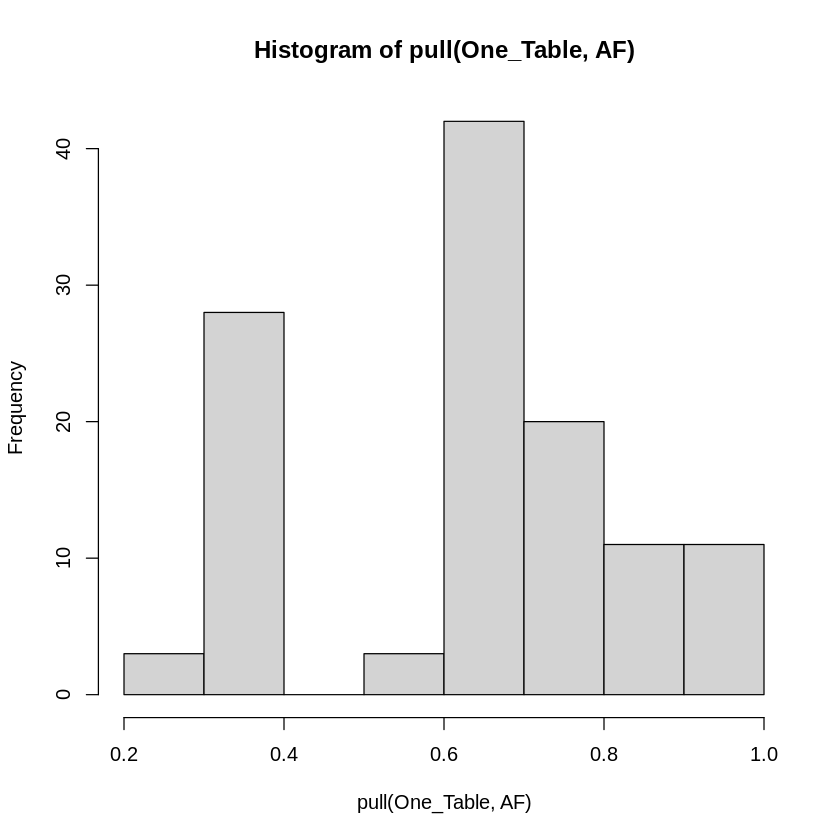

In [4]:
# we need to know which direction the distortion is and how strong it is
# to distinguish different cases

# just add AF to all TRD regions

One_Table<-mutate(One_Table, AF=NA)

for(i in 1:nrow(One_Table)){
    OT_slice<-slice(One_Table, i)
    AF_file<-paste0("/home/jnrunge/data/TRD/results/shiny/",pull(OT_slice, cross),"-AF.csv.gz")
    AF<-fread(AF_file)
    AF<-filter(AF, chr==pull(OT_slice,chr) & global_pos >= pull(OT_slice, global_start) & global_pos <= pull(OT_slice, global_end))
    AF_value<-mean(pull(AF,AD_A1)/pull(AF,sumCount))
    One_Table<-mutate(One_Table, AF=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),
                                           AF_value, AF))
}

hist(pull(One_Table, AF))

One_Table<-mutate(One_Table, Distorter=ifelse(AF>0.5,"1","2"))

Warning message:
"package 'ggplot2' was built under R version 4.1.3"
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


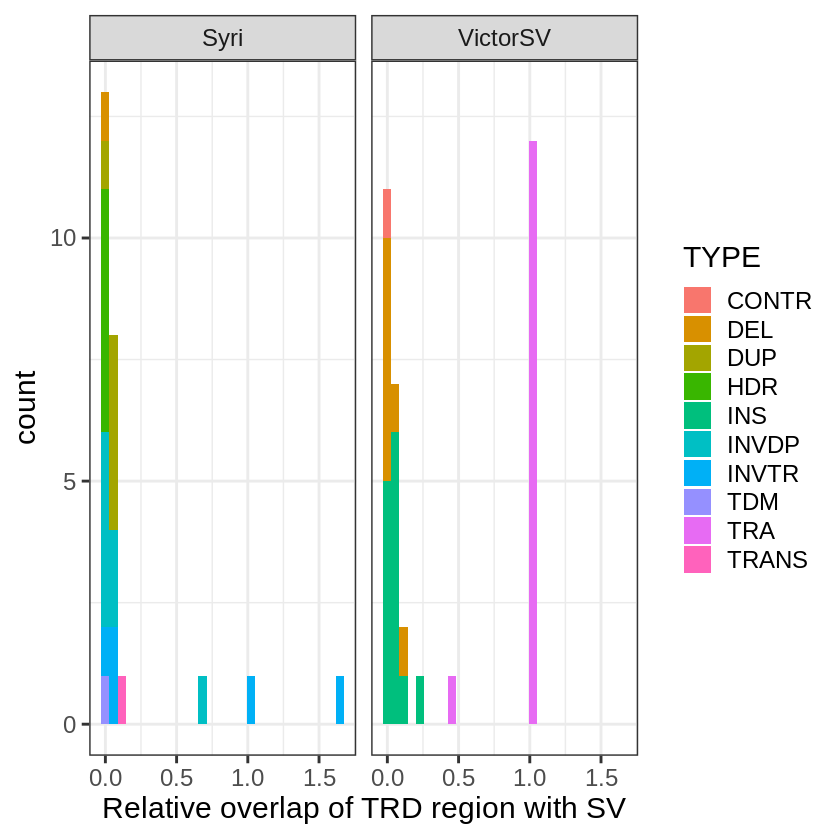

In [5]:
# What sort of SVs are involved?

library(ggplot2)
ggplot(SV_data_summary%>%filter(sum_LEN_rel>=0.01), aes(sum_LEN_rel, fill=TYPE))+
geom_histogram()+
facet_wrap(~source)+#+scale_y_log10()
theme_bw(18)+
xlab("Relative overlap of TRD region with SV")

In [6]:
# add a column that says if this TRD if this cross's strongest TRD

One_Table <- One_Table %>% 
  group_by(cross) %>%
  mutate(strongest = abs(AF - 0.5) == max(abs(AF - 0.5), na.rm = TRUE)) %>%
  ungroup()


Call:
lm(formula = tree_changes_raw ~ log(lengthBp), data = One_Table)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.51014 -0.17564 -0.03690  0.07657  1.64486 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    9.55006    0.48546   19.67   <2e-16 ***
log(lengthBp) -0.58015    0.04031  -14.39   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2921 on 115 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.643,	Adjusted R-squared:  0.6399 
F-statistic: 207.1 on 1 and 115 DF,  p-value: < 2.2e-16


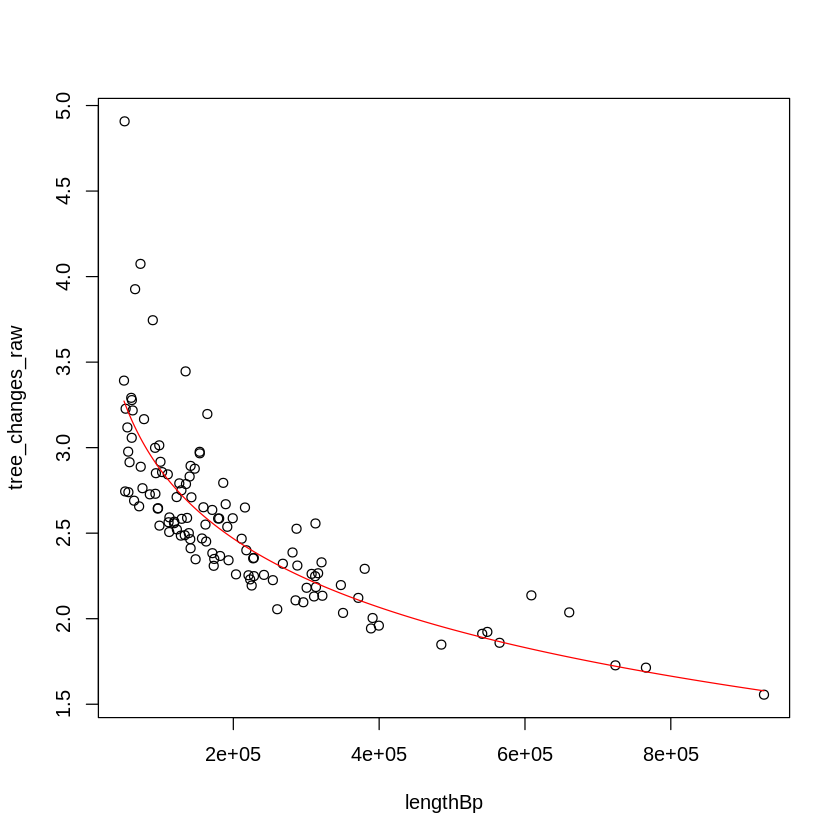

In [7]:
# quick evidence that tree changes at TRD locus needed to be corrected for size of TRD region
# the necessary changes have been made to 02_Local-Phylogeny now.

poly_model <- lm(tree_changes_raw ~ log(lengthBp), data = One_Table)
summary(poly_model)
x <- with(One_Table, seq(min(lengthBp), max(lengthBp), length.out=2000))
y <- predict(poly_model, newdata = data.frame(lengthBp = x))

plot(tree_changes_raw ~ lengthBp, data = One_Table)
lines(x, y, col = "red")

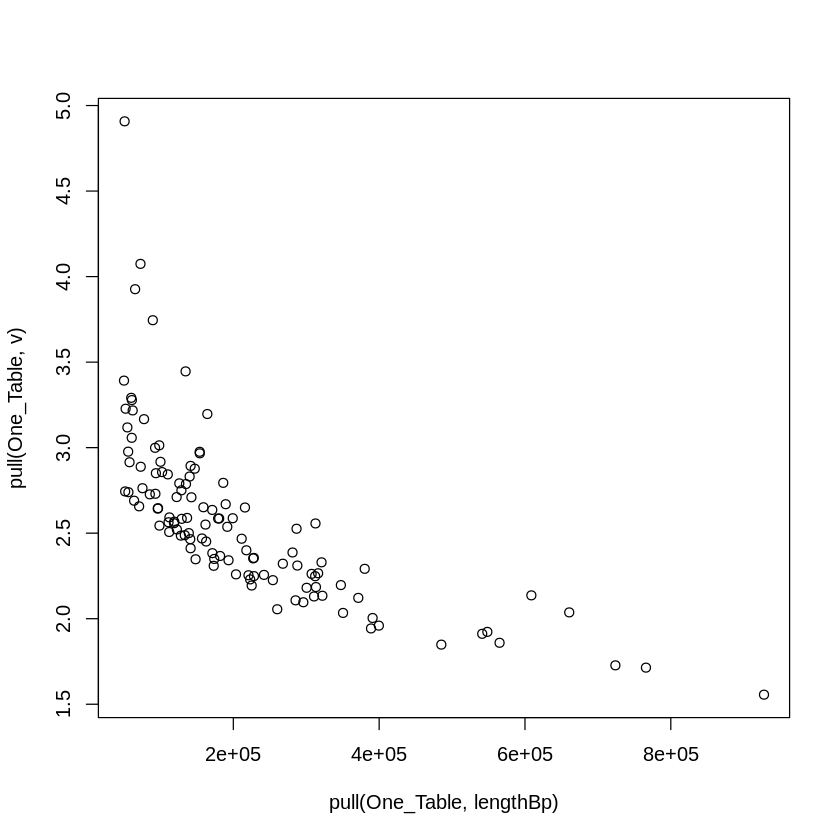

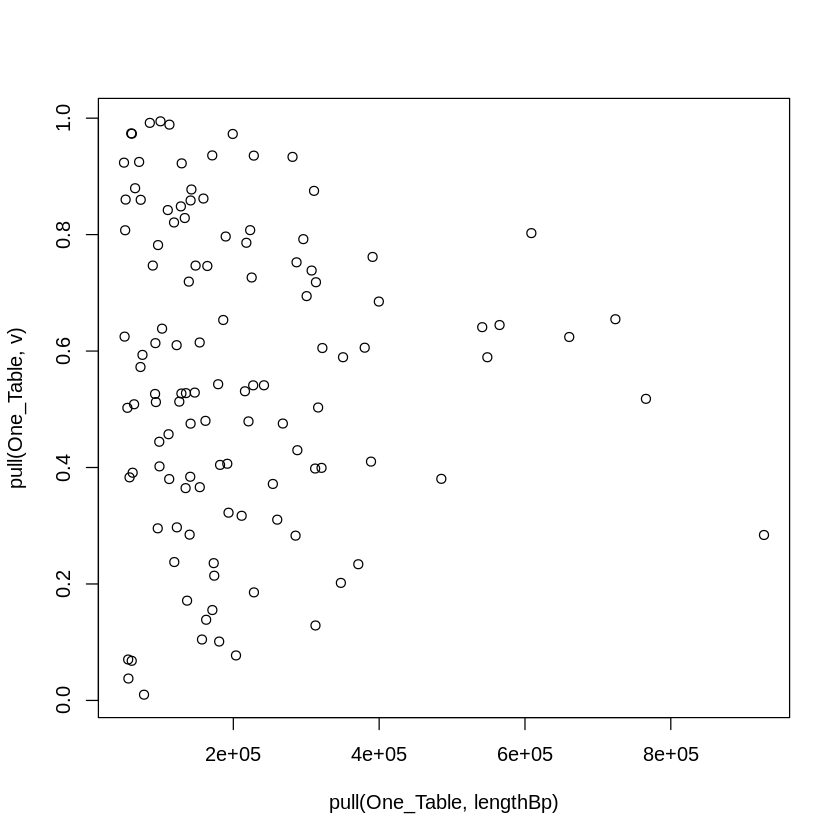

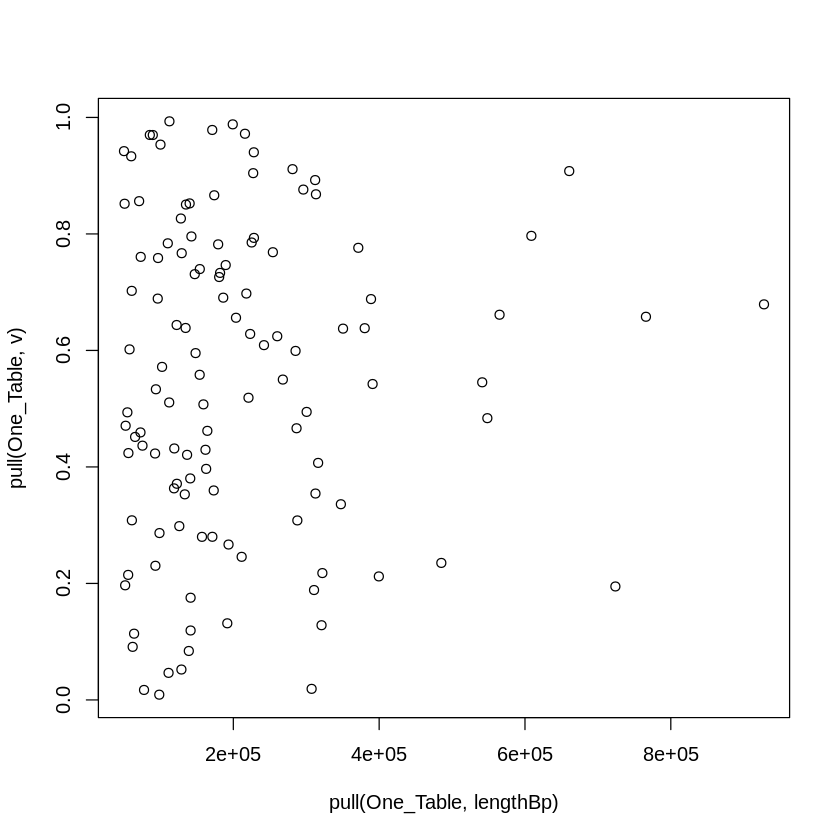

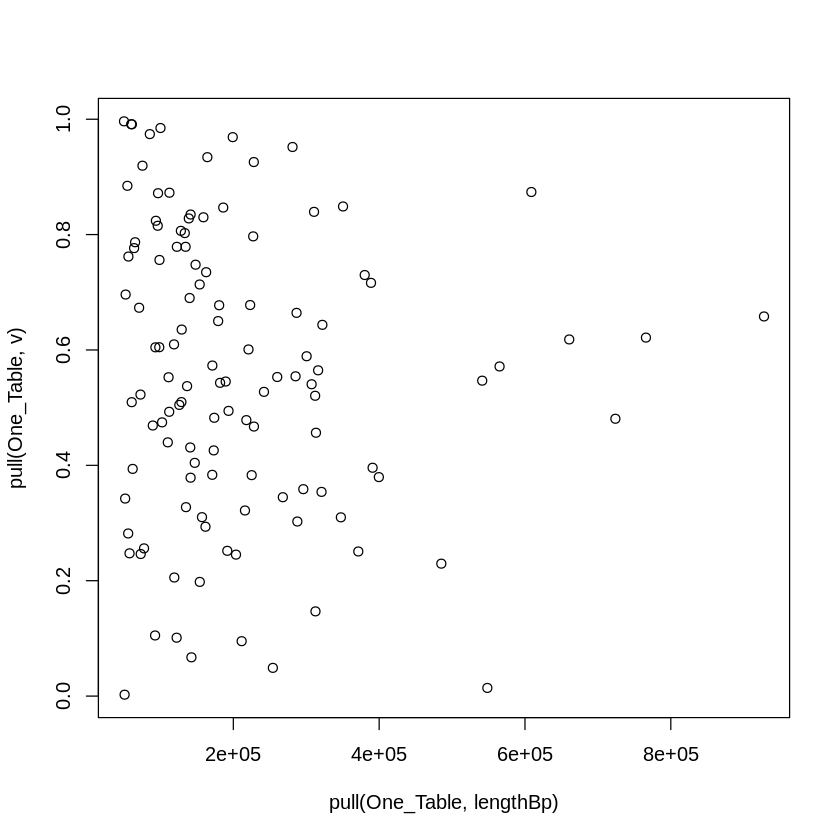

value,pAnova
<chr>,<dbl>
tree_changes_raw,1.574341e-19
PCA_eucldist_quantile_1,6.301501e-01
PCA_eucldist_quantile_2,5.580841e-01
IBS_eucldist_quantile_1,3.297874e-01
IBS_eucldist_quantile_2,2.403217e-01


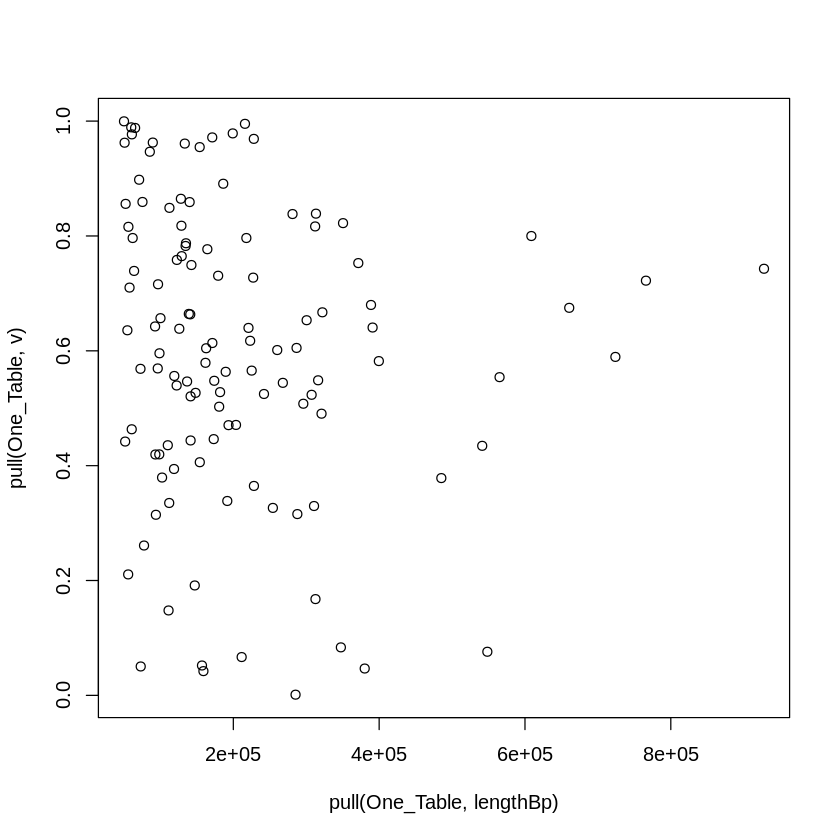

In [8]:
# the same is not the case for other local phylogeny measures
lp_bias<-data.table(value=c("tree_changes_raw","PCA_eucldist_quantile_1",
                           "PCA_eucldist_quantile_2","IBS_eucldist_quantile_1",
                           "IBS_eucldist_quantile_2"), pAnova=NA)
for(v in pull(lp_bias,value)){
    lp_bias<-mutate(lp_bias, pAnova=ifelse(value==v, anova(lm(pull(One_Table,v)~pull(One_Table, lengthBp)), lm(pull(One_Table,v)~1, One_Table))$`Pr(>F)`[2],pAnova))
    plot(pull(One_Table,v)~pull(One_Table, lengthBp))
}

lp_bias

In [9]:
options(repr.plot.width=10, repr.plot.height=10)

# LP data prep

library(stringr)
library(tidyverse)

LP_colnames=c("PCA_eucldist_quantile_1","PCA_eucldist_sd_multiplier_1","IBS_eucldist_quantile_1","IBS_eucldist_sd_multiplier_1","tree_changes_quantile","tree_changes_sd_multiplier","PCA_eucldist_quantile_2","PCA_eucldist_sd_multiplier_2","IBS_eucldist_quantile_2","IBS_eucldist_sd_multiplier_2")
#LP_colnames=LP_colnames[grepl("quant",LP_colnames,fixed=TRUE)]
LP_summary<-pivot_longer(One_Table%>%select(Distorter, strongest, all_of(LP_colnames)), cols = LP_colnames)
LP_summary <- LP_summary %>% mutate(Distorter = case_when(
  substr(name, nchar(name), nchar(name)) %in% c("1", "2") & 
    substr(name, nchar(name), nchar(name)) == Distorter ~ TRUE,
  substr(name, nchar(name), nchar(name)) %in% c("1", "2") ~ FALSE,
  TRUE ~ NA_real_
))
LP_summary <- LP_summary %>% mutate(name = str_remove(name, "_[12]$"))

LP_summary <- LP_summary %>% 
  group_by(name) %>% 
  mutate(value_normalized = ifelse(grepl("quant",name,fixed=TRUE),value-0.5,value)) %>% 
  ungroup()

Warning message:
"package 'stringr' was built under R version 4.1.3"
Warning message:
"package 'tidyverse' was built under R version 4.1.3"
-- Attaching packages ----------------------------------------------------------------------------------------- tidyverse 1.3.2 --
v tibble  3.1.8     v purrr   1.0.1
v tidyr   1.3.0     v dplyr   1.1.0
v readr   2.1.3     v forcats 1.0.0
Warning message:
"package 'tibble' was built under R version 4.1.3"
Warning message:
"package 'tidyr' was built under R version 4.1.3"
Warning message:
"package 'readr' was built under R version 4.1.3"
Warning message:
"package 'purrr' was built under R version 4.1.3"
Warning message:
"package 'dplyr' was built under R version 4.1.3"
Warning message:
"package 'forcats' was built under R version 4.1.3"
-- Conflicts -------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::across()                masks tidytable::across()
x dplyr::add_count()      

Next I am showing that the IBS and PCA values are overall higher than from the expected value (0.5 / 0.0), but not by much and the SD data indicates this to be perhaps driven by a few extreme examples, promising potential for interpretation.

Whether the value is taken from distorter or disorted does not matter, however, indicating more general changes at the locus.

**tree data not yet interpreted due to unfinished fix**


	One Sample t-test

data:  filter(LP_summary, name == "IBS_eucldist_quantile") %>% pull(value)
t = 4.6726, df = 233, p-value = 5.03e-06
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5442221 0.6087026
sample estimates:
mean of x 
0.5764623 



	One Sample t-test

data:  filter(LP_summary, name == "PCA_eucldist_quantile") %>% pull(value)
t = 3.0377, df = 233, p-value = 0.002656
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5184539 0.5865742
sample estimates:
mean of x 
 0.552514 



	One Sample t-test

data:  filter(LP_summary, name == "IBS_eucldist_sd_multiplier") %>% pull(value)
t = 2.9429, df = 233, p-value = 0.00358
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.06618072 0.33428269
sample estimates:
mean of x 
0.2002317 



	One Sample t-test

data:  filter(LP_summary, name == "PCA_eucldist_sd_multiplier") %>% pull(value)
t = 1.2154, df = 233, p-value = 0.2254
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.04906082  0.20707397
sample estimates:
 mean of x 
0.07900658 



	Welch Two Sample t-test

data:  filter(LP_summary, Distorter == TRUE, name == "IBS_eucldist_quantile") %>% pull(value) and filter(LP_summary, Distorter == FALSE, name == "IBS_eucldist_quantile") %>% pull(value)
t = 0.27331, df = 227.32, p-value = 0.7849
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.05565466  0.07357993
sample estimates:
mean of x mean of y 
0.5809437 0.5719810 



	Welch Two Sample t-test

data:  filter(LP_summary, Distorter == TRUE, name == "PCA_eucldist_quantile") %>% pull(value) and filter(LP_summary, Distorter == FALSE, name == "PCA_eucldist_quantile") %>% pull(value)
t = -0.33753, df = 230.98, p-value = 0.736
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.07994578  0.05656092
sample estimates:
mean of x mean of y 
0.5466678 0.5583603 



	Welch Two Sample t-test

data:  filter(LP_summary, Distorter == TRUE, name == "IBS_eucldist_sd_multiplier") %>% pull(value) and filter(LP_summary, Distorter == FALSE, name == "IBS_eucldist_sd_multiplier") %>% pull(value)
t = 0.36063, df = 230.86, p-value = 0.7187
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.2194512  0.3177825
sample estimates:
mean of x mean of y 
0.2248145 0.1756489 



	Welch Two Sample t-test

data:  filter(LP_summary, Distorter == TRUE, name == "PCA_eucldist_sd_multiplier") %>% pull(value) and filter(LP_summary, Distorter == FALSE, name == "PCA_eucldist_sd_multiplier") %>% pull(value)
t = -0.10349, df = 229.99, p-value = 0.9177
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.2701811  0.2432145
sample estimates:
 mean of x  mean of y 
0.07226494 0.08574821 


name,mean
<chr>,<dbl>
IBS_eucldist_quantile,0.57646234
IBS_eucldist_sd_multiplier,0.20023170
PCA_eucldist_quantile,0.55251404
PCA_eucldist_sd_multiplier,0.07900658
tree_changes_quantile,0.00000000
tree_changes_sd_multiplier,-9.76786123


Distorter,strongest,name,value,value_normalized
<dbl>,<lgl>,<chr>,<dbl>,<dbl>
0,FALSE,PCA_eucldist_quantile,0.2972387,-0.2027613
0,FALSE,PCA_eucldist_sd_multiplier,-0.2679710,-0.2679710
0,FALSE,IBS_eucldist_quantile,0.7788144,0.2788144
0,FALSE,IBS_eucldist_sd_multiplier,0.1348451,0.1348451
NA,FALSE,tree_changes_quantile,0.0000000,-0.5000000
NA,FALSE,tree_changes_sd_multiplier,-9.8582350,-9.8582350


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 10 rows containing non-finite values (`stat_bin()`)."


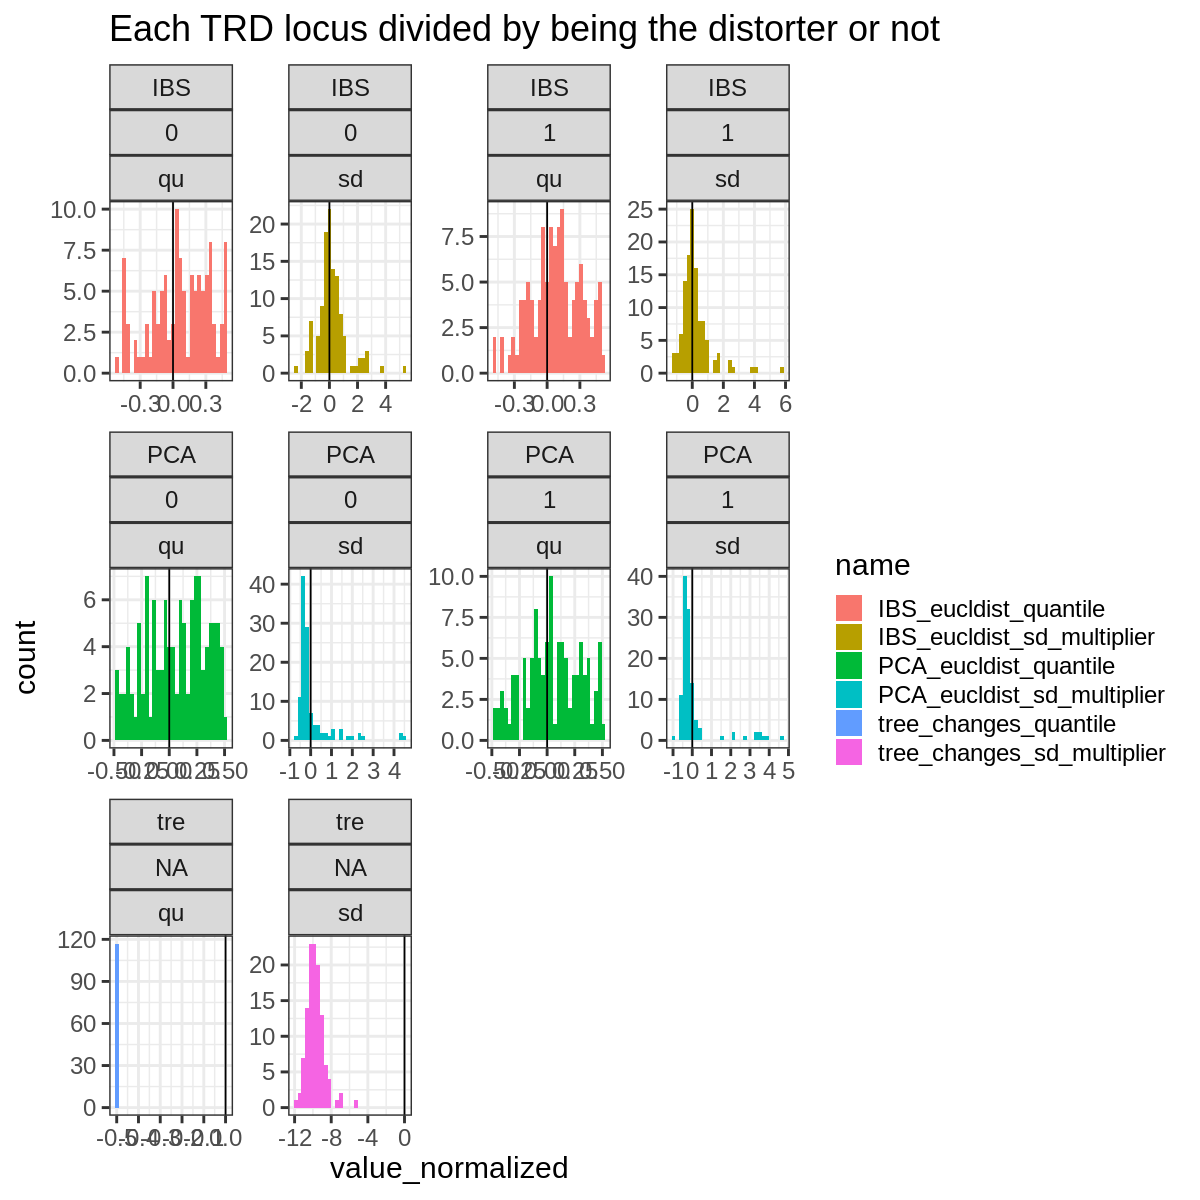

In [10]:
t.test(filter(LP_summary, name == "IBS_eucldist_quantile")%>%pull(value), mu=0.5)
t.test(filter(LP_summary, name == "PCA_eucldist_quantile")%>%pull(value), mu=0.5)
t.test(filter(LP_summary, name == "IBS_eucldist_sd_multiplier")%>%pull(value), mu=0)
t.test(filter(LP_summary, name == "PCA_eucldist_sd_multiplier")%>%pull(value), mu=0)

t.test(filter(LP_summary, Distorter==TRUE, name == "IBS_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==FALSE, name == "IBS_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)
t.test(filter(LP_summary, Distorter==TRUE, name == "PCA_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==FALSE, name == "PCA_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)
t.test(filter(LP_summary, Distorter==TRUE, name == "IBS_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==FALSE, name == "IBS_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)
t.test(filter(LP_summary, Distorter==TRUE, name == "PCA_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==FALSE, name == "PCA_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)

LP_summary%>%group_by(name)%>%summarize(mean=mean(value,na.rm=TRUE))

head(LP_summary)
ggplot(LP_summary, aes(value_normalized,fill=name))+
geom_histogram(position="dodge")+geom_vline(xintercept=0)+
facet_wrap(~substr(name,1,3)+Distorter+substr(name,14,15),scales="free")+theme_bw(18)+ggtitle("Each TRD locus divided by being the distorter or not")

In [11]:
# does not matter if we are looking at the strongest distorter

t.test(filter(LP_summary, Distorter==TRUE&strongest==TRUE, name == "IBS_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==TRUE&strongest==FALSE, name == "IBS_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==TRUE&strongest==TRUE, name == "PCA_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==TRUE&strongest==FALSE, name == "PCA_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==TRUE&strongest==TRUE, name == "IBS_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==TRUE&strongest==FALSE, name == "IBS_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==TRUE&strongest==TRUE, name == "PCA_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==TRUE&strongest==FALSE, name == "PCA_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==FALSE&strongest==TRUE, name == "IBS_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==FALSE&strongest==FALSE, name == "IBS_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==FALSE&strongest==TRUE, name == "PCA_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==FALSE&strongest==FALSE, name == "PCA_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==FALSE&strongest==TRUE, name == "IBS_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==FALSE&strongest==FALSE, name == "IBS_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==FALSE&strongest==TRUE, name == "PCA_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==FALSE&strongest==FALSE, name == "PCA_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

[1] 0.924079

[1] 0.3117151

[1] 0.8885751

[1] 0.5720348

[1] 0.6557946

[1] 0.1115239

[1] 0.9327494

[1] 0.1746352

In [12]:
# pixy data overview

pixy_files<-list.files("/home/jnrunge/data/trd/pop_genomics","relative-measures.RDS$",full.names = TRUE)
pixy_df<-data.table()
for(f in pixy_files){
    f_<-readRDS(f)


f_ <- lapply(f_, function(x) {
  if ("pi_pop" %in% names(x)) {
    names(x)[names(x) == "pi_pop"] <- "sum_value"
  }
  x
})

df <- f_ %>%
  purrr::imap_dfr(function(y, name) {
    data.table(analysis = name, t(y))
  })
    
    df<-mutate(df, file=basename(f))
    
    pixy_df<-bind_rows(pixy_df, df)
    
}
pixy_df<-mutate(pixy_df, ecdf_value=as.numeric(ecdf_value))
pixy_df<-mutate(pixy_df, standardized_measure=as.numeric(standardized_measure))
pixy_df<-mutate(pixy_df, sum_value=as.numeric(sum_value))
pixy_df_OG<-pixy_df
head(pixy_df)






analysis,sum_value,ecdf_value,standardized_measure,file
<chr>,<dbl>,<dbl>,<dbl>,<chr>
pi_distorter,0.0010105359,0.3667482,-0.08784650,ChrisC1.1-relative-measures.RDS
pi_other,0.0066415474,0.9249171,0.13720789,ChrisC1.1-relative-measures.RDS
fst,0.0942122786,0.7417693,0.32274522,ChrisC1.1-relative-measures.RDS
dxy,0.0049723317,0.8780999,0.06872751,ChrisC1.1-relative-measures.RDS
pi_distorter,0.0006102738,0.4769056,-0.07291594,ChrisC1.2-relative-measures.RDS
pi_other,0.0042263674,0.6212346,-0.04251747,ChrisC1.2-relative-measures.RDS


In [13]:
getCrossAndID=function(x){
    x<-strsplit(x, "-", fixed=TRUE)[[1]][1]
    x<-strsplit(x, ".", fixed=TRUE)[[1]]
    return(data.table(cross=x[1], ID=x[2]))
}

pixy_df<-bind_cols(pixy_df, bind_rows(lapply(pull(pixy_df, file), getCrossAndID)))
head(pixy_df)
pixy_df%>%pull(cross)%>%unique()

pixy_df<-select(pixy_df, -file)%>%
  pivot_wider(names_from = analysis, 
              values_from = c(sum_value, ecdf_value, standardized_measure),
              names_sep = "_",
              id_cols = c(cross, ID))


analysis,sum_value,ecdf_value,standardized_measure,file,cross,ID
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
pi_distorter,0.0010105359,0.3667482,-0.08784650,ChrisC1.1-relative-measures.RDS,ChrisC1,1
pi_other,0.0066415474,0.9249171,0.13720789,ChrisC1.1-relative-measures.RDS,ChrisC1,1
fst,0.0942122786,0.7417693,0.32274522,ChrisC1.1-relative-measures.RDS,ChrisC1,1
dxy,0.0049723317,0.8780999,0.06872751,ChrisC1.1-relative-measures.RDS,ChrisC1,1
pi_distorter,0.0006102738,0.4769056,-0.07291594,ChrisC1.2-relative-measures.RDS,ChrisC1,2
pi_other,0.0042263674,0.6212346,-0.04251747,ChrisC1.2-relative-measures.RDS,ChrisC1,2


[1] "ChrisC1" "ChrisC3" "ChrisC4" "ChrisC5" "ChrisC7" "ChrisC8" "YJNRC12"
 [8] "YJNRC14" "YJNRC15" "YJNRC18" "YJNRC19" "YJNRC2"  "YJNRC20" "YJNRC21"
[15] "YJNRC22" "YJNRC23" "YJNRC24" "YJNRC25" "YJNRC26" "YJNRC27" "YJNRC29"
[22] "YJNRC3"  "YJNRC30" "YJNRC31" "YJNRC32" "YJNRC4"  "YJNRC5"  "YJNRC6" 
[29] "YJNRC7"  "YJNRC8"  "YJNRC9"

In [14]:
pixy_df<-mutate(pixy_df, ID=as.numeric(ID))
One_Table<-full_join(One_Table, pixy_df, by=c("cross","ID"))

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 848 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 848 rows containing missing values (`geom_point()`)."


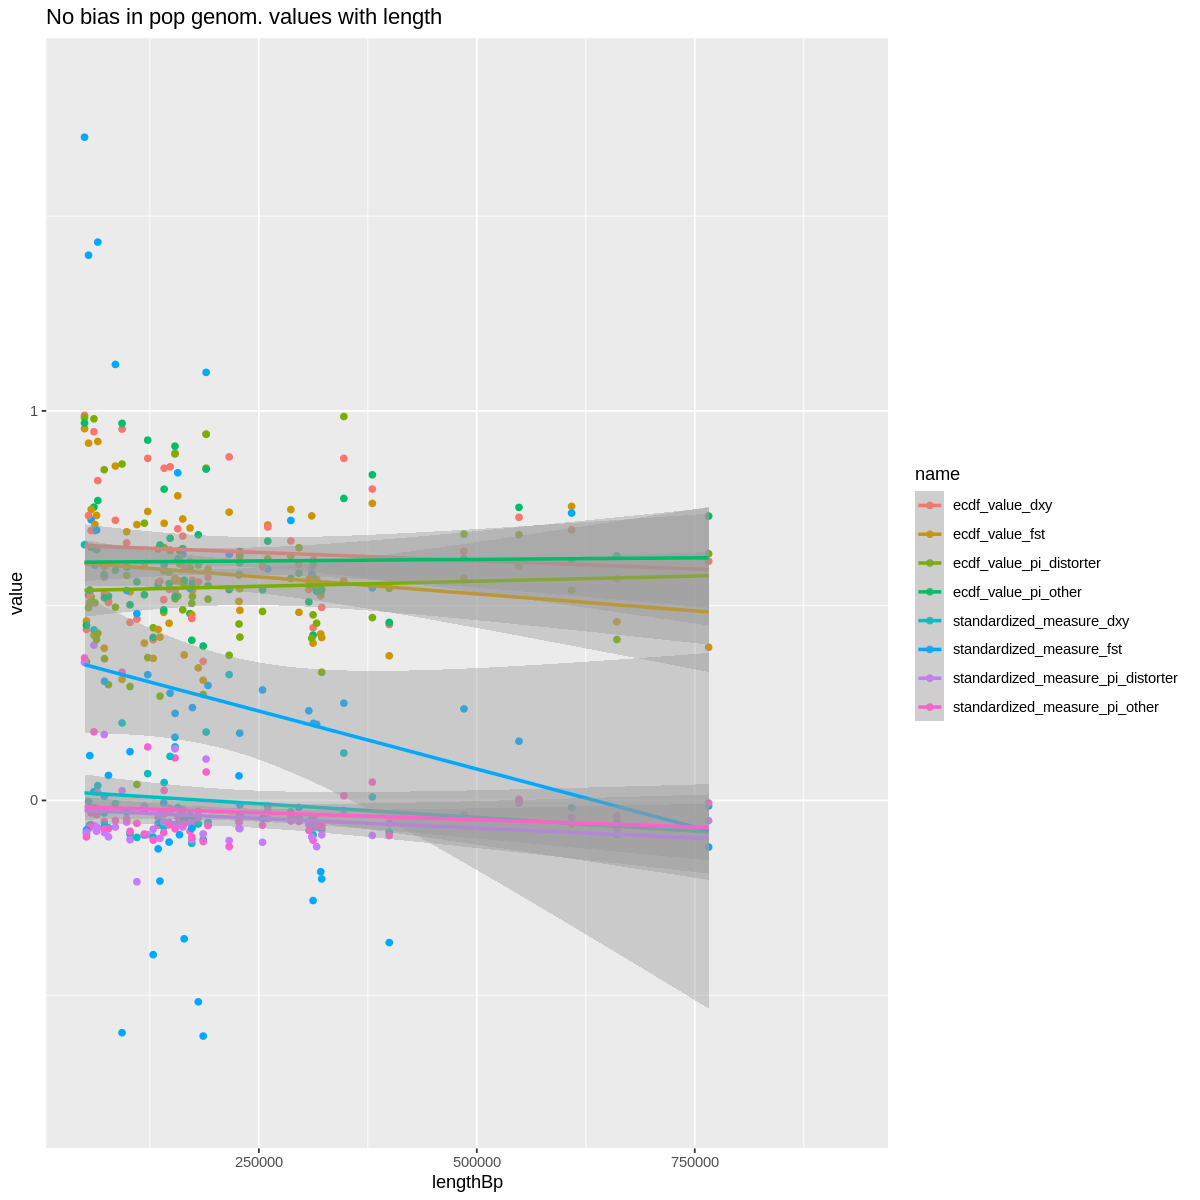

In [15]:
ggplot(One_Table%>%select(cross,ID,ecdf_value_fst,ecdf_value_dxy,ecdf_value_pi_distorter,ecdf_value_pi_other,standardized_measure_fst,standardized_measure_dxy,standardized_measure_pi_distorter,standardized_measure_pi_other,lengthBp)%>%
pivot_longer(cols = c(ecdf_value_fst, ecdf_value_dxy, ecdf_value_pi_distorter, 
                        ecdf_value_pi_other, standardized_measure_fst, standardized_measure_dxy, 
                        standardized_measure_pi_distorter, standardized_measure_pi_other)),
       aes(lengthBp, value, color=name))+
geom_point()+geom_smooth(method="lm")+ggtitle("No bias in pop genom. values with length")

evidence that fst is increased at trd loci, but mixed results for other values; probably more interesting to look at specific examples

In [16]:
pixy_global_tests<-data.table(value=c("ecdf_value_fst","ecdf_value_dxy","ecdf_value_pi_distorter","ecdf_value_pi_other","standardized_measure_fst","standardized_measure_dxy","standardized_measure_pi_distorter","standardized_measure_pi_other"),
                             p=NA, mean=NA)
for(i in 1:nrow(pixy_global_tests)){
    pgt_slice<-slice(pixy_global_tests, i)
    pgt_slice_value<-pull(pgt_slice, value)
    ttest_value<-t.test(pull(One_Table, pgt_slice_value), mu=ifelse(startsWith(pgt_slice_value,"ecdf"),0.5,0))$p.value
    pixy_global_tests<-mutate(pixy_global_tests, p=ifelse(value==pgt_slice_value,ttest_value,p))
    pixy_global_tests<-mutate(pixy_global_tests, mean=ifelse(value==pgt_slice_value,mean(pull(One_Table, pgt_slice_value),na.rm=TRUE),mean))
}
pixy_global_tests

value,p,mean
<chr>,<dbl>,<dbl>
ecdf_value_fst,4.025918e-10,0.604617218
ecdf_value_dxy,2.131779e-17,0.643508088
ecdf_value_pi_distorter,1.983939e-02,0.544893996
ecdf_value_pi_other,1.310162e-11,0.613936773
standardized_measure_fst,2.076779e-09,0.309039140
standardized_measure_dxy,6.730841e-01,0.007891785
standardized_measure_pi_distorter,8.331972e-07,-0.047053891
standardized_measure_pi_other,3.513981e-04,-0.032862020


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 54 rows containing non-finite values (`stat_bin()`)."


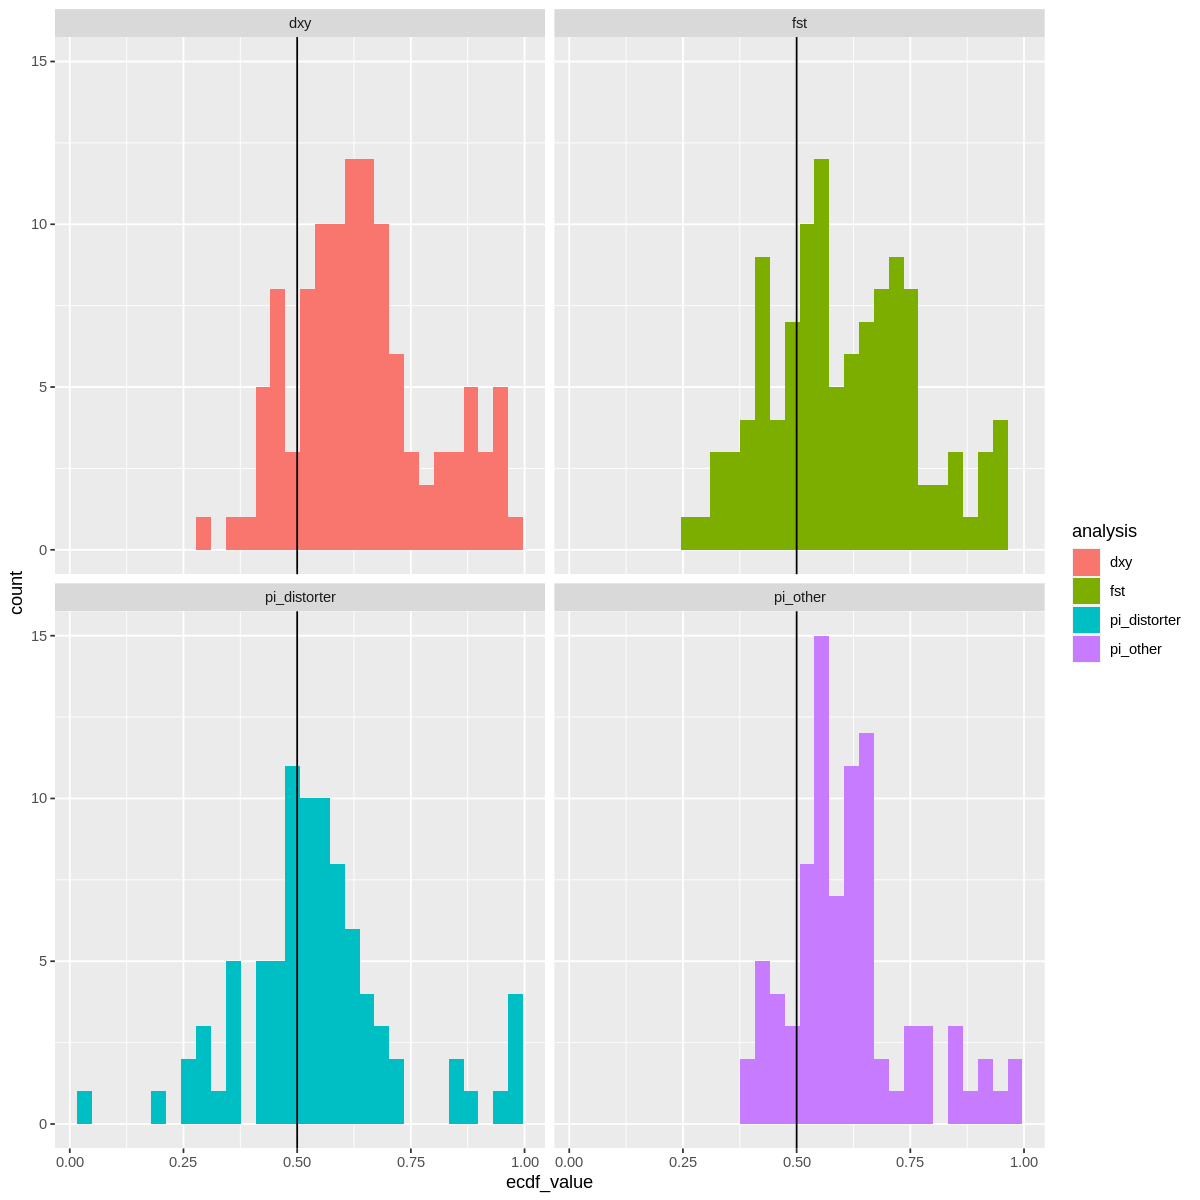

In [17]:
ggplot(pixy_df_OG, aes(ecdf_value, fill=analysis))+
geom_histogram()+facet_wrap(~analysis)+geom_vline(xintercept = 0.5)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 54 rows containing non-finite values (`stat_bin()`)."


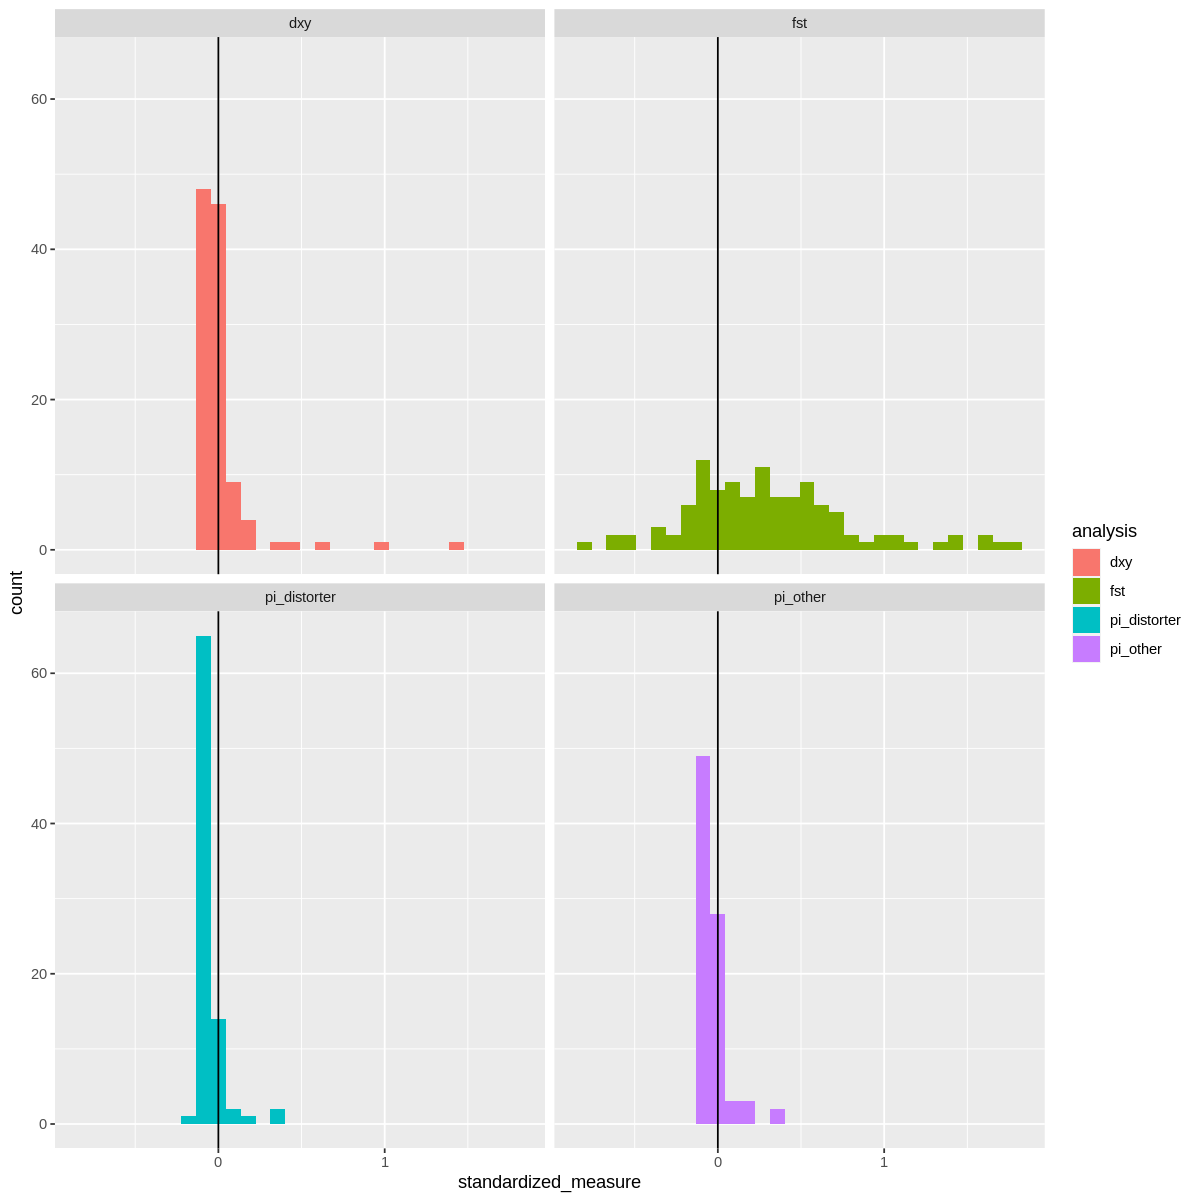

In [18]:
ggplot(pixy_df_OG, aes(standardized_measure, fill=analysis))+
geom_histogram()+facet_wrap(~analysis)+geom_vline(xintercept = 0)

In [19]:
colnames(One_Table)

[1] "ID"                                "lengthSNPs"                       
 [3] "chr"                               "global_start"                     
 [5] "global_end"                        "lengthBp"                         
 [7] "cross"                             "start"                            
 [9] "end"                               "PCA_eucldist_quantile_1"          
[11] "PCA_eucldist_sd_multiplier_1"      "IBS_eucldist_quantile_1"          
[13] "IBS_eucldist_sd_multiplier_1"      "tree_changes_quantile"            
[15] "tree_changes_sd_multiplier"        "tree_changes_raw"                 
[17] "PCA_eucldist_quantile_2"           "PCA_eucldist_sd_multiplier_2"     
[19] "IBS_eucldist_quantile_2"           "IBS_eucldist_sd_multiplier_2"     
[21] "AF"                                "Distorter"                        
[23] "strongest"                         "sum_value_pi_distorter"           
[25] "sum_value_pi_other"                "sum_value_fst"                    
[27] "sum_value_dxy"                     "ecdf_value_pi_distorter"          
[29] "ecdf_value_pi_other"               "ecdf_value_fst"                   
[31] "ecdf_value_dxy"                    "standardized_measure_pi_distorter"
[33] "standardized_measure_pi_other"     "standardized_measure_fst"         
[35] "standardized_measure_dxy"

In [28]:
# add SV data to big table
One_Table<-left_join(One_Table,pivot_wider(SV_data_summary, id_cols=c("cross","ID"), names_from=c("TYPE","source"), values_from = c("sum_LEN_rel"), values_fill = 0), by=c("cross","ID"))

In [30]:
# add LD and TD data
LD_data<-fread("/home/jnrunge/data/trd/LD_data/LD_plot_data.csv.gz")
TD_data<-fread("/home/jnrunge/data/trd/TD_data/TD_plot_data.csv.gz")

One_Table<-left_join(One_Table, LD_data)
One_Table<-left_join(One_Table, TD_data)

Joining with `by = join_by(ID, cross)`
Joining with `by = join_by(ID, cross)`


In [37]:
paste(colnames(One_Table),collapse=",")

[1] "ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end,PCA_eucldist_quantile_1,PCA_eucldist_sd_multiplier_1,IBS_eucldist_quantile_1,IBS_eucldist_sd_multiplier_1,tree_changes_quantile,tree_changes_sd_multiplier,tree_changes_raw,PCA_eucldist_quantile_2,PCA_eucldist_sd_multiplier_2,IBS_eucldist_quantile_2,IBS_eucldist_sd_multiplier_2,AF,Distorter,strongest,sum_value_pi_distorter,sum_value_pi_other,sum_value_fst,sum_value_dxy,ecdf_value_pi_distorter,ecdf_value_pi_other,ecdf_value_fst,ecdf_value_dxy,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,CPG_Syri,CPL_Syri,DEL_Syri,DEL_VictorSV,DUP_Syri,DUP_VictorSV,HDR_Syri,INS_Syri,INS_VictorSV,INVDP_Syri,TDM_Syri,TRANS_Syri,INVTR_Syri,TRA_VictorSV,CONTR_VictorSV,LD_sd_multi_1,LD_sd_multi_2,TD_sd_multi,TD_ecdf"

In [50]:
scale_numeric<-function(x){
    return(as.numeric(scale(x)))
}

In [75]:
# getting rid of the SVs and also NAs
clustering_subset<-select(One_Table, AF,
                         PCA_eucldist_quantile_1,PCA_eucldist_sd_multiplier_1,IBS_eucldist_quantile_1,IBS_eucldist_sd_multiplier_1,
                          #tree_changes_quantile,tree_changes_sd_multiplier,tree_changes_raw,
                          PCA_eucldist_quantile_2,PCA_eucldist_sd_multiplier_2,IBS_eucldist_quantile_2,IBS_eucldist_sd_multiplier_2,sum_value_pi_distorter,sum_value_pi_other,sum_value_fst,sum_value_dxy,ecdf_value_pi_distorter,ecdf_value_pi_other,ecdf_value_fst,ecdf_value_dxy,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,LD_sd_multi_1,LD_sd_multi_2,TD_sd_multi,TD_ecdf)

clustering_subset <- clustering_subset %>% mutate(AF=abs(AF-0.5)) %>%
  # Scale all columns
  mutate_all(~ scale_numeric(.)) %>%
  # Convert to rowwise data frame
  rowwise() %>%
  # Remove rows with NA values
  filter(!any(is.na(c_across(everything()))))

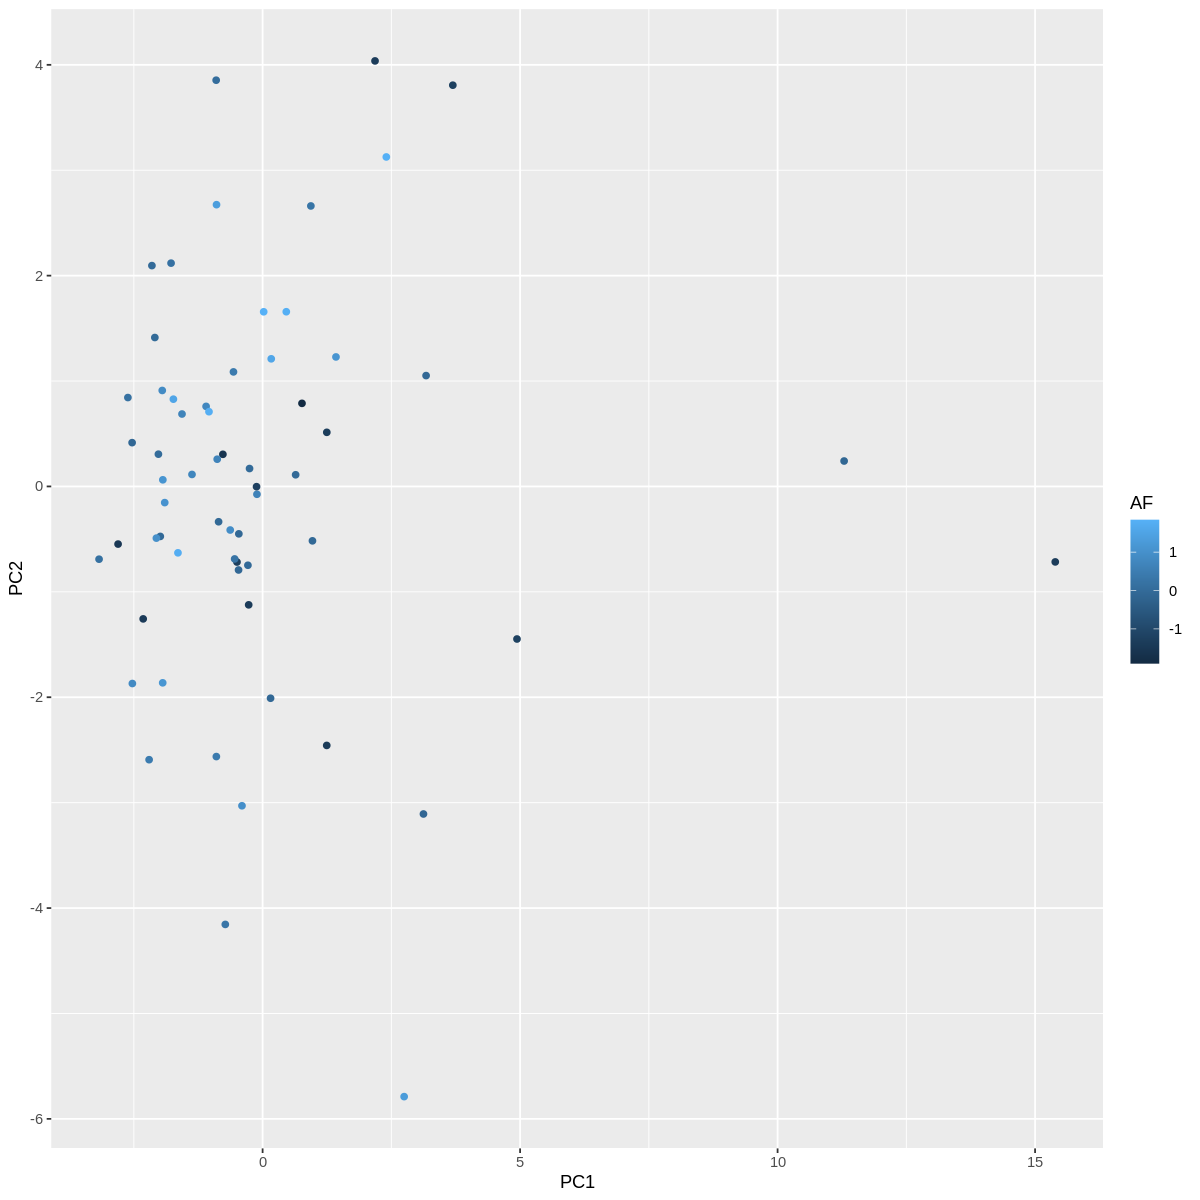

In [81]:
pca_df<-bind_cols(clustering_subset,as.data.frame(prcomp(select(clustering_subset, -AF))$x))
ggplot(pca_df,
      aes(PC1,PC2,color=AF))+
geom_point()

In [127]:
cluster_transposed<-t(as.data.frame(select(clustering_subset, -AF)))
colnames(cluster_transposed)<-1:ncol(cluster_transposed)

Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_label_repel()`)."


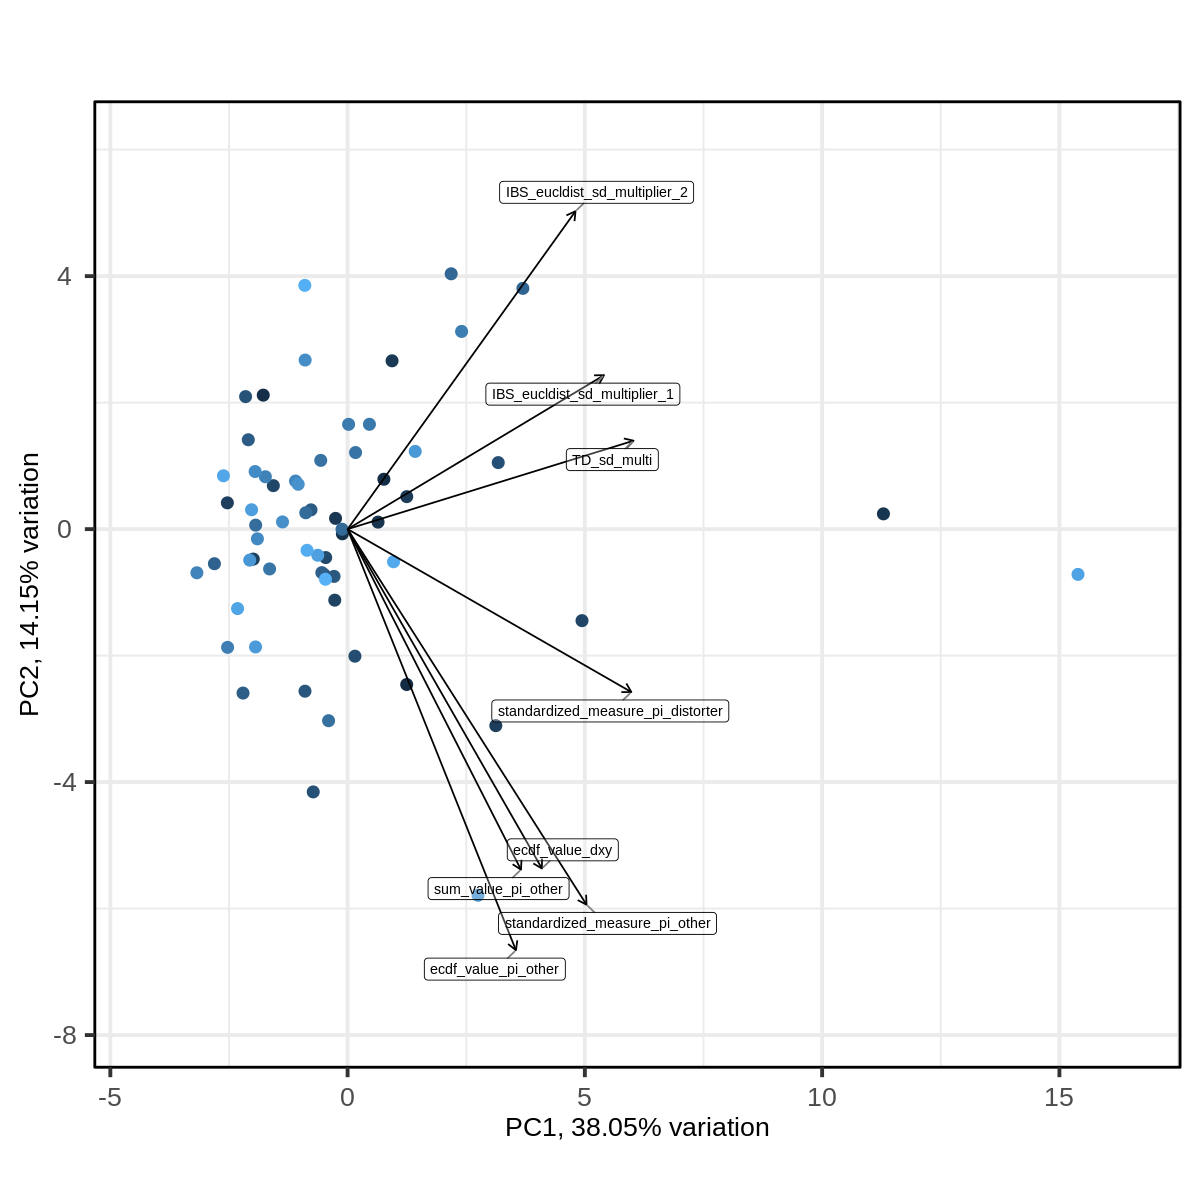

In [128]:
# why different results?

library(PCAtools)
p <- pca(cluster_transposed)
biplot(p, showLoadings = TRUE, lab = NULL, showLoadingsNames=TRUE, )


In [84]:
classify_values=function(x){
    # to group the TRD regions, I am classifying them by whether they are average or strong
    if(x >= 1){
        return("high")
    }
    if(x <= -1){
        return("weak")
    }
    return("average")
}
l_classify_values=function(x){
    return(unlist(lapply(x, classify_values)))
}

In [90]:
clustering_subset%>%
mutate_all(~ l_classify_values(.))%>%
group_by_all()%>%summarize(n=n())%>%arrange(-n)

`summarise()` has grouped output by 'AF', 'PCA_eucldist_quantile_1', 'PCA_eucldist_sd_multiplier_1', 'IBS_eucldist_quantile_1',
'IBS_eucldist_sd_multiplier_1', 'PCA_eucldist_quantile_2', 'PCA_eucldist_sd_multiplier_2', 'IBS_eucldist_quantile_2',
'IBS_eucldist_sd_multiplier_2', 'sum_value_pi_distorter', 'sum_value_pi_other', 'sum_value_fst', 'sum_value_dxy',
'ecdf_value_pi_distorter', 'ecdf_value_pi_other', 'ecdf_value_fst', 'ecdf_value_dxy', 'standardized_measure_pi_distorter',
'standardized_measure_pi_other', 'standardized_measure_fst', 'standardized_measure_dxy', 'LD_sd_multi_1', 'LD_sd_multi_2',
'TD_sd_multi'. You can override using the `.groups` argument.


AF,PCA_eucldist_quantile_1,PCA_eucldist_sd_multiplier_1,IBS_eucldist_quantile_1,IBS_eucldist_sd_multiplier_1,PCA_eucldist_quantile_2,PCA_eucldist_sd_multiplier_2,IBS_eucldist_quantile_2,IBS_eucldist_sd_multiplier_2,sum_value_pi_distorter,...,ecdf_value_dxy,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,LD_sd_multi_1,LD_sd_multi_2,TD_sd_multi,TD_ecdf,n
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
average,average,average,average,average,high,average,average,average,average,...,average,average,average,average,average,average,average,average,average,2
average,average,average,average,average,weak,average,average,average,average,...,average,average,average,average,average,average,average,average,average,2
average,average,average,average,average,weak,average,average,average,average,...,weak,average,average,weak,average,average,average,average,average,2
average,average,average,average,average,average,average,average,average,average,...,average,average,average,average,average,average,average,average,average,1
average,average,average,average,average,average,average,average,average,average,...,high,average,average,average,average,average,average,average,average,1
average,average,average,average,average,average,average,average,average,average,...,weak,average,average,average,average,weak,weak,average,average,1
average,average,average,average,average,average,average,average,average,average,...,average,average,average,average,average,average,average,average,average,1
average,average,average,average,average,average,average,average,average,high,...,high,high,high,high,average,average,average,average,average,1
average,average,average,average,average,average,average,weak,average,average,...,average,average,average,average,average,average,average,average,average,1


In [81]:
SV_data_org<-SV_data

In [88]:
cross_render<-"ChrisC1"
cross<-cross_render
rmarkdown::render("03_RegionReportTemplate.Rmd", params = 
                  list(cross=cross),
                  output_file = paste0("~/TRD/03_GenomicSignals/PDF_reports/",cross, '.HTML'), 
                 )



processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                   


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/ChrisC1.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/ChrisC1.HTML



In [ ]:
 # the render function seems to overwrite variables...
for(cross_render in select(One_Table, cross)%>%distinct()%>%pull(cross))
    {
    #if(nrow(filter(SV_data_org, cross==cross_render))==0){
    #    next
    #}
    cross<-cross_render
    print(cross_render)
    rmarkdown::render("03_RegionReportTemplate.Rmd", params = 
                  list(cross=cross),
                  output_file = paste0("~/TRD/03_GenomicSignals/PDF_reports/",cross, '.HTML'), 
                 )
}



[1] "ChrisC1"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                   


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/ChrisC1.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/ChrisC1.HTML



[1] "ChrisC3"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                   


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/ChrisC3.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/ChrisC3.HTML



[1] "ChrisC4"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                   


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/ChrisC4.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/ChrisC4.HTML



[1] "ChrisC5"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                   


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/ChrisC5.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/ChrisC5.HTML



[1] "ChrisC7"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                   


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/ChrisC7.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/ChrisC7.HTML



[1] "ChrisC8"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                   


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/ChrisC8.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/ChrisC8.HTML



[1] "YJNRC12"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                   


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC12.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC12.HTML



[1] "YJNRC14"




processing file: 03_RegionReportTemplate.Rmd



  |.................................................  |  97%                    (unnamed-chunk-1)                     (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                   